<a href="https://colab.research.google.com/gist/shreyas0328/84b0c633d38103abeb2bd6a0ff5e5109/resnet50-to-cifar-10-with-padding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import datasets
from torchvision import transforms
from torchvision.models.resnet import resnet50
from PIL import Image

In [ ]:
pimg_size = (224,224) # resnet image size is 224,224
img_size = (28,28) #MNIST
mask_size = pimg_size #size of masking matrix
num_channels = 3 # num channels for resnet
batch_size = 20

In [ ]:
pad = int((pimg_size[0]-img_size[0])/2) # finding what padding I need on each border of the input image


transform = transforms.Compose([
    transforms.Pad(padding = [0,0,pad,pad]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
# adding padding, normalizing the data, and using lambda to up the num of channels

train_dataset = datasets.MNIST(root = 'data/', train=True, transform=transform, download=True) # download  dataset

test_dataset = datasets.MNIST(root = 'data/', train=False, transform=transform)


train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size, shuffle=True
)



test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size, shuffle=False
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/


In [ ]:
device = torch.device('cuda:0') # using GPU
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model.to(device)
model.eval()
for param in model.parameters():
    param.requires_grad = False

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [ ]:
program = torch.rand(num_channels, *pimg_size, device=device, requires_grad = True) #creating our adversarial program starting point by making a random tensor, which we will adjust later


mask_pad = int((mask_size[0]-img_size[0])/2)

mask = torch.zeros(num_channels, *img_size, device=device) # creating the mask
mask = F.pad(mask, (0, pad, 0, pad), value=1)


optimizer = torch.optim.Adam([program], lr=0.05) #the optimizer which optimizes our adversarial program
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma =0.96)# to adjust the learning rate as time goes on

loss_criterion = nn.CrossEntropyLoss() # loss criterion


num_classes = 10 # num classes for MNSIST

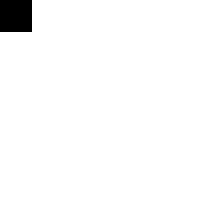

In [ ]:
transforms.ToPILImage()(mask.detach().cpu())

In [ ]:
for data in train_loader:
    images = data[0].to(device)
    for i in images[0]:
        asdf = i
        break
    break

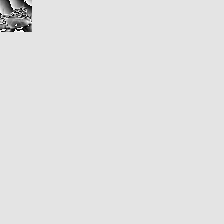

In [ ]:
transforms.ToPILImage()(asdf.detach().cpu())

In [ ]:
#Training loop
num_epochs = 20
steps_per_epoch = len(train_loader)

for epoch in range(num_epochs):

    if epoch == 0:
      print('Training has started')


    total_loss = 0.0

    for i, data in enumerate(train_loader):
      images = data[0].to(device) #grabbing images from the data
      labels = data[1].to(device) #grabbing labels from the data

      images = images + torch.tanh(program*mask) #additive contribution to the image

      outputs = model(images) # see what resnet classifies
      outputs = outputs[:,:num_classes] #only care about first 10 cause MNIST only has 10 classes.

      loss = loss_criterion(outputs, labels) # find loss
      loss.backward() # backwards pass
      optimizer.step() #update weights
      optimizer.zero_grad()


      total_loss += loss.item() #calculate total loss

      if(i+1)%(steps_per_epoch/2) == 0:
        print(f'Epoch {epoch+1}/{num_epochs},  Step {i+1}/{steps_per_epoch},  Loss:  {loss.item()},  Avg Loss for Epoch:  {total_loss/(i+1)}')
    lr_scheduler.step() # adjusting learning rate

Training has started
Epoch 1/20,  Step 1250/2500,  Loss:  1.5080654621124268,  Avg Loss for Epoch:  1.8856442170143128
Epoch 1/20,  Step 2500/2500,  Loss:  1.5110949277877808,  Avg Loss for Epoch:  1.7683265078544617
Epoch 2/20,  Step 1250/2500,  Loss:  1.4726181030273438,  Avg Loss for Epoch:  1.559734135055542
Epoch 2/20,  Step 2500/2500,  Loss:  1.391950249671936,  Avg Loss for Epoch:  1.5333985775470733
Epoch 3/20,  Step 1250/2500,  Loss:  1.3145709037780762,  Avg Loss for Epoch:  1.4807712861061095
Epoch 3/20,  Step 2500/2500,  Loss:  1.3400521278381348,  Avg Loss for Epoch:  1.4737130031108856
Epoch 4/20,  Step 1250/2500,  Loss:  1.3700437545776367,  Avg Loss for Epoch:  1.461430593776703
Epoch 4/20,  Step 2500/2500,  Loss:  1.4329593181610107,  Avg Loss for Epoch:  1.455592224574089
Epoch 5/20,  Step 1250/2500,  Loss:  1.4588369131088257,  Avg Loss for Epoch:  1.4424003604888915
Epoch 5/20,  Step 2500/2500,  Loss:  1.7891252040863037,  Avg Loss for Epoch:  1.4464255179166794
Epo

In [ ]:
# testing
with torch.no_grad():

  total_loss = 0.0
  total_steps = len(test_loader)
  total = 0
  total_correct = 0


  for data in test_loader:
      images = data[0].to(device)
      labels = data[1].to(device)

      images = images + torch.tanh(program*mask)
      outputs = model(images)
      outputs = outputs[:,:num_classes]

      preds = torch.argmax(torch.softmax(outputs, dim =1), dim = 1) #grabs index of highest pred

      total_correct += torch.sum(preds==labels).item()
      total+= labels.shape[0]


In [ ]:
acc = (total_correct/total) * 100.0
print(f'Accuracy: {acc:.4f}')

Accuracy: 48.4500
